authors: Xue (Lily) Yang, git@lilyportfolio, Siqi Li, git@Vincey777

# Importing Libraries



In [ ]:
#These libraries help to interact with the operating system and the runtime environment respectively
import os
import sys

#Model/Training related libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
import csv
import pandas as pd
import random
from matplotlib import pyplot as plt

#Dataloader libraries
from torch.utils.data import DataLoader, Dataset

In [ ]:
if __name__ == '__main__':
    #GPU Check
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    num_workers = 8 if cuda else 0
    print('Cuda = ', cuda, 'num of workers =', num_workers, "system version = ", sys.version)

Cuda =  True num of workers = 8 system version =  3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]


In [ ]:
torch.cuda.empty_cache()
random.seed(1234)

In [ ]:
!nvidia-smi

Sun Nov 28 20:50:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P2    35W / 151W |   3154MiB /  8097MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tuning args

In [ ]:
tuning_args = {
    'batch_size': 512,
    'num_epochs': 100
    }

# Setting up Data

## 1. Load Data and Data Preprocessing

### Parse data points and split

In [ ]:
def parse_data(datadir):
    data_list = []
    for root, directories, filenames in os.walk(datadir):
        for filename in filenames:
            if filename.endswith('.npy'):
                filei = os.path.join(root, filename)
                data_list.append(filei)
    return data_list

In [ ]:
data_path = "psam_pusa/"
data_list = parse_data(data_path)
lengths = [int(len(data_list)*0.7), int(len(data_list)*0.2), int(len(data_list)*0.1)]
print(lengths)
random.shuffle(data_list)

[1161165, 331761, 165880]


In [ ]:
train_list = data_list[:lengths[0]]
val_list = data_list[lengths[0]:lengths[0]+lengths[1]]
test_list = data_list[-lengths[2]:]

### Data Removal

In [ ]:
import csv
data = pd.read_csv("psam_pusa_colnames.csv") 

#### Remove income related columns

In [ ]:
numeric_indices = data[~data.iloc[:, 1].str.contains('PINCP|INTP|OIP|PAP|RETP|SEMP|SSIP|SSP|WAGP|PERNP', regex=True)]

#### >60% null values

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('GCM_|DRAT_|SFN_|SFR_|NOP_|ESP_|GCR_|FHINS5C_|FOD2P_|MLPK_|MLPJ_|VPS_|MLPB_|MLPH_|MLPFG_|MLPE_\
                                                                           |MLPCD_|MLPI_|CITWP_|DRATX_|SCHG_|MIGSP_|MIGPUMA_|FHINS4C_|YOEP|DECADE_|ENG_|LANP_|FER_\
                                                                           |FHINS3C_|SCIENGRLP_|SCIENGP_', regex=True)]

#### Drop Flags > 99%

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FANCP|FDRATP|FDRATXP|FGCLP|FGCMP|FMILPP|FWRKP|FSEXP', regex=True)]

#### Drop Redundant Flags

In [ ]:
numeric_indices = numeric_indices[~numeric_indices.iloc[:, 1].str.contains('FYOEP|FWKHP|FWAGP|FSSP|FSSIP|FSEMP|FRETP|FRELSHIPP|FPOWSP|FPOBP|FPINCP|FPERNP|FPAP|FOIP|FOCCP\
                                                                           |FMIGSP|FMARHYP|FLANP|FJWRIP|FJWMNP|FJWDP|FINTP|FINDP|FHISP|FCITWP|FAGEP', regex=True)]

In [ ]:
numeric_indices_list = numeric_indices.iloc[:, 0].tolist()

## 2. Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.datalist = data_list
        self.count = 0

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, i):
        
        data_array = np.load(self.datalist[i])
        
        # ignore data that have age under 16
        age = int(data_array[2])

        if age >= 16:
            
            Y = np.array(np.log(data_array[19], where=data_array[19]>0))
            Y = np.array(np.nan_to_num(Y))

            # drop_list = ['INTP - 4', 'OIP -8', 'PAP -9', 'RETP- 10', 'SEMP -11', 'SSIP -12', 'SSP-13', 'WAGP -14', 'PERNP -18']
            X = np.array(data_array[numeric_indices_list])
            X = np.array(np.nan_to_num(X))

            return torch.FloatTensor(X), torch.FloatTensor(Y)

def my_collate(batch):
    batch = list(filter(lambda x : x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

## 3. Initialize Dataloader

In [ ]:
# Training dataloader
train_data = CustomDataset(train_list)
train_args = dict(shuffle = True, batch_size = tuning_args['batch_size'], num_workers=8)
train_loader = DataLoader(train_data, **train_args, collate_fn=my_collate)

# Validation dataloader
val_data = CustomDataset(val_list)
val_args = dict(shuffle = False, batch_size = tuning_args['batch_size'], num_workers=8)
val_loader = DataLoader(val_data, **val_args, collate_fn=my_collate)

In [ ]:
# Test Loader
test_data = CustomDataset(test_list)
test_args = dict(shuffle = False, batch_size = tuning_args['batch_size'], num_workers=8)
test_loader = DataLoader(test_data, **test_args, collate_fn=my_collate)

# Build Model

## 1. OLS

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X_train = []
y_train = []

for i in range(500000):
    if train_data[i] is not None:
        X_train.append(train_data[i][0].numpy())
        # y_train.append(train_data[i][1].numpy())

print(len(X_train))

414666


## 2. SVD

In [ ]:
from scipy.linalg import svd

svd_array = np.array(X_train)
U, s, VT = svd(svd_array, full_matrices = False)

In [ ]:
model_args = {
    'learning_rate': 5e-4, #5e-4 -model2, #0.001 - model1,
    'model_num': '5',
    'model_size': [len(train_data[0][0]), 10000, 1]
    }

## 3. MLP - no hidden

In [ ]:
class OLS(nn.Module):

    # define model elements
    def __init__(self, size):
        super(OLS, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(size[0], size[2]))

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
model_OLS = OLS(model_args['model_size'])
model_OLS.weight = s
model_OLS.to(device)

# Define Criterion/ Loss function
criterion = nn.MSELoss()

# Define Adam Optimizer
optimizer = torch.optim.Adam(model_OLS.parameters(), lr = model_args['learning_rate'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

print(model_OLS)

OLS(
  (model): Sequential(
    (0): Linear(in_features=4331, out_features=1, bias=True)
  )
)


## 4. MLP

In [ ]:
class MLP(nn.Module):

    # define model elements
    def __init__(self, size):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(nn.Linear(size[0], size[0]), 
                                   # nn.BatchNorm1d(size[0]),
                                   nn.ReLU(),
                                   # nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[0], size[1]),
                                   # nn.BatchNorm1d(size[1]),
                                   # nn.ReLU(),
                                   nn.Sigmoid(),
                                   # nn.SiLU(),
                                   # nn.Dropout(model_args['dropout']),
                                   
                                   nn.Linear(size[1], size[2]))

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
model = MLP(model_args['model_size'])
model.weight = s
model.to(device)

# Define Criterion/ Loss function
criterion = nn.MSELoss()

# Define Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = model_args['learning_rate'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=4331, out_features=4331, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4331, out_features=10000, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10000, out_features=1, bias=True)
  )
)


# Run

## 1. Train

In [ ]:
def train_model(train_loader, model):
    training_loss = 0.0
    
    # Set model in 'Training mode'
    model.train()
    
    start_time = time.time()
    
    # enumerate mini batches
    for i, (inputs, targets) in tqdm(enumerate(train_loader), position=0, leave=True):
        # clear the gradients
        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the model output
        out = model(inputs).squeeze()
        
        # calculate loss
        loss = criterion(out, targets)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()

        training_loss += loss.item()
        
        end_time = time.time()
    
    training_loss /= len(val_loader)
    
    print('Training loss: {:.5f}, Time: {}s'.format(training_loss, end_time - start_time))
    
    return training_loss

## 2. Eval

In [ ]:
def evaluate_model(val_loader, model):
    
    batch_count = 0
    running_loss = 0.0
    predictions_list = []
    targets_list = []
    
    # Set model in validation mode
    with torch.no_grad():
        
        model.eval()
        model.to(device)
        
        for i, (inputs, targets) in tqdm(enumerate(val_loader), position=0, leave=True):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # evaluate the model on the validation set
            out = model(inputs).squeeze()
            
            # Calculate validation loss
            loss = criterion(out, targets)
        
            pred = out.data
            
            batch_count += targets.size(0)
            running_loss += loss.item()
            
            pred_cpu = pred.detach().cpu().numpy()
            target_cpu = targets.view(-1).detach().cpu().numpy()
            
            predictions_list.append(pred_cpu)
            targets_list.append(target_cpu)
            
            running_loss /= batch_count
        
        print('Validation loss: {:.5}'.format(running_loss))
        
    return running_loss, predictions_list, targets_list

## 3. OLS - run

In [ ]:
final_r2 = -100.0
training_loss_list = []
val_loss_list = []
r2_list = []

for epoch in range(1):
    print('Epoch #{}'.format(epoch+1))
    start_time = time.time()
    
    # Train
    training_loss = train_model(train_loader, model_OLS)
    training_loss_list.append(training_loss)

    # Validation
    val_loss, pred_list, target_list = evaluate_model(val_loader, model_OLS)
    val_loss_list.append(val_loss)
    
    pred_flat = np.concatenate([x.ravel() for x in pred_list])
    target_flat = np.concatenate([x.ravel() for x in target_list])

    set_r2 = r2_score(pred_flat, target_flat)
    r2_list.append(set_r2)
    
    # scheduler (to allow learning rate to change)
    scheduler.step()

    #if at a particular epoch, save model
    if set_r2 > final_r2:

        checkpoint = {
            'state_dict': model_OLS.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict()
        }

        torch.save(checkpoint, 'model'+ model_args['model_num'] + '_OLS_' + str(set_r2) + '.pth')
        
        final_r2 = set_r2
    
    end_time = time.time()
    
    print('Set R2:{:.5f}, Epoch Time: {}s'.format(set_r2, end_time - start_time))
    print('='*60)

print('OLS Done')

Epoch #1


2268it [03:47,  9.98it/s]

Training loss: 1427.73048, Time: 228.24406099319458s



648it [01:04, 10.09it/s]

Validation loss: 0.0013519
Set R2:-2.49652, Epoch Time: 293.88041949272156s
OLS Done


## 4. MLP - run

In [ ]:
epochs = tuning_args['num_epochs']

final_r2 = 0.0
training_loss_list = []
val_loss_list = []
r2_list = []

for epoch in range(epochs):
    print('Epoch #{}'.format(epoch+1))
    start_time = time.time()
    
    # Train
    training_loss = train_model(train_loader, model)
    training_loss_list.append(training_loss)

    # Validation
    val_loss, pred_list, target_list = evaluate_model(val_loader, model)
    val_loss_list.append(val_loss)
    
    pred_flat = np.concatenate([x.ravel() for x in pred_list])
    target_flat = np.concatenate([x.ravel() for x in target_list])

    set_r2 = r2_score(pred_flat, target_flat)
    r2_list.append(set_r2)
    
    # scheduler (to allow learning rate to change)
    scheduler.step()

    #if at a particular epoch, save model
    if set_r2 > final_r2:

        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict()
        }

        torch.save(checkpoint, 'model'+ model_args['model_num'] + '_' + str(epoch+1) + '_' + str(set_r2) + '.pth')
        
        final_r2 = set_r2
    
    end_time = time.time()
    
    print('Set R2:{:.5f}, Epoch Time: {}s'.format(set_r2, end_time - start_time))
    print('='*60)

print('MLP Done')

Epoch #1


2268it [03:40, 10.31it/s]

Training loss: 15.19606, Time: 220.94589376449585s



648it [01:03, 10.21it/s]


Validation loss: 9.4447e-06
Set R2:0.64110, Epoch Time: 287.1486186981201s
Epoch #2


2268it [03:39, 10.35it/s]

Training loss: 10.07786, Time: 220.0882489681244s



648it [01:02, 10.44it/s]

Validation loss: 8.4904e-06


Set R2:0.69442, Epoch Time: 284.77088713645935s
Epoch #3


2268it [03:36, 10.47it/s]

Training loss: 9.41217, Time: 217.85762763023376s



648it [01:00, 10.67it/s]


Validation loss: 8.8303e-06
Set R2:0.71473, Epoch Time: 281.22382712364197s
Epoch #4


2268it [03:40, 10.29it/s]

Training loss: 8.93741, Time: 221.60241389274597s



648it [01:04, 10.12it/s]


Validation loss: 9.0745e-06
Set R2:0.71644, Epoch Time: 288.47264075279236s
Epoch #5


2268it [03:41, 10.25it/s]

Training loss: 8.64817, Time: 222.5878505706787s



648it [01:02, 10.34it/s]


Validation loss: 8.0991e-06
Set R2:0.74578, Epoch Time: 288.43292689323425s
Epoch #6


2268it [03:37, 10.44it/s]

Training loss: 8.37074, Time: 218.40361905097961s



648it [01:00, 10.64it/s]


Validation loss: 8.2457e-06
Set R2:0.75060, Epoch Time: 282.5586667060852s
Epoch #7


2268it [03:38, 10.36it/s]

Training loss: 8.05300, Time: 220.2743582725525s



648it [01:01, 10.61it/s]

Validation loss: 7.4463e-06
Set R2:0.74004, Epoch Time: 283.33137798309326s
Epoch #8



2268it [03:37, 10.41it/s]

Training loss: 7.77060, Time: 219.19840550422668s



648it [01:03, 10.17it/s]


Validation loss: 7.5685e-06
Set R2:0.75664, Epoch Time: 286.1544759273529s
Epoch #9


2268it [03:42, 10.19it/s]

Training loss: 7.57943, Time: 224.12884521484375s



648it [01:01, 10.52it/s]


Validation loss: 7.5298e-06
Set R2:0.77069, Epoch Time: 288.9538879394531s
Epoch #10


2268it [03:41, 10.25it/s]

Training loss: 8.93786, Time: 222.61165738105774s



648it [01:03, 10.25it/s]

Validation loss: 8.4498e-06
Set R2:0.60869, Epoch Time: 287.8457283973694s
Epoch #11



2268it [03:35, 10.53it/s]

Training loss: 8.72314, Time: 216.60655188560486s



648it [01:00, 10.64it/s]

Validation loss: 8.0035e-06
Set R2:0.70216, Epoch Time: 279.46685886383057s
Epoch #12



2268it [03:33, 10.61it/s]

Training loss: 8.57727, Time: 215.0008420944214s



648it [01:00, 10.69it/s]

Validation loss: 7.9587e-06
Set R2:0.72927, Epoch Time: 277.70821142196655s
Epoch #13



2268it [03:36, 10.45it/s]

Training loss: 8.41320, Time: 218.20150542259216s



648it [01:02, 10.33it/s]

Validation loss: 8.0267e-06
Set R2:0.77034, Epoch Time: 282.99437975883484s
Epoch #14



2268it [03:34, 10.58it/s]

Training loss: 8.22321, Time: 215.6039216518402s



648it [01:00, 10.75it/s]

Validation loss: 7.5206e-06
Set R2:0.73860, Epoch Time: 277.8904151916504s
Epoch #15



2268it [03:32, 10.68it/s]

Training loss: 7.91648, Time: 213.47845029830933s



648it [01:00, 10.73it/s]

Validation loss: 7.0472e-06
Set R2:0.74130, Epoch Time: 275.89366459846497s
Epoch #16



2268it [03:33, 10.61it/s]

Training loss: 7.68909, Time: 214.99694514274597s



648it [01:02, 10.41it/s]


Validation loss: 8.0404e-06
Set R2:0.77525, Epoch Time: 280.3384439945221s
Epoch #17


2268it [03:35, 10.54it/s]

Training loss: 7.46358, Time: 216.58368301391602s



648it [01:00, 10.76it/s]

Validation loss: 8.2185e-06
Set R2:0.77276, Epoch Time: 278.8206989765167s
Epoch #18



2268it [03:35, 10.51it/s]

Training loss: 7.23270, Time: 217.09162974357605s



648it [01:00, 10.79it/s]

Validation loss: 7.6532e-06
Set R2:0.75532, Epoch Time: 279.14857840538025s
Epoch #19



2268it [03:30, 10.75it/s]

Training loss: 7.06651, Time: 212.18054127693176s



648it [01:00, 10.78it/s]

Validation loss: 7.8051e-06
Set R2:0.77103, Epoch Time: 274.26389503479004s
Epoch #20



2268it [03:32, 10.70it/s]

Training loss: 8.35342, Time: 213.22641229629517s



648it [01:00, 10.72it/s]

Validation loss: 8.2564e-06
Set R2:0.74947, Epoch Time: 275.72259187698364s
Epoch #21



2268it [03:32, 10.68it/s]

Training loss: 8.23382, Time: 213.60476279258728s



648it [01:02, 10.42it/s]

Validation loss: 7.6426e-06
Set R2:0.76760, Epoch Time: 277.8461844921112s
Epoch #22



2268it [03:32, 10.68it/s]

Training loss: 8.10369, Time: 213.52764415740967s



648it [01:00, 10.75it/s]

Validation loss: 7.0123e-06
Set R2:0.75026, Epoch Time: 275.76991987228394s
Epoch #23



2268it [03:34, 10.59it/s]

Training loss: 7.99875, Time: 215.43980646133423s



648it [01:00, 10.77it/s]

Validation loss: 7.6563e-06
Set R2:0.77209, Epoch Time: 277.63317680358887s
Epoch #24



2268it [03:33, 10.62it/s]

Training loss: 7.81211, Time: 214.74569869041443s



648it [01:00, 10.79it/s]

Validation loss: 7.9503e-06
Set R2:0.74881, Epoch Time: 276.86379837989807s
Epoch #25



2268it [03:33, 10.61it/s]

Training loss: 7.55119, Time: 214.8935022354126s



648it [01:00, 10.77it/s]

Validation loss: 7.857e-06
Set R2:0.77023, Epoch Time: 277.10790967941284s
Epoch #26



2268it [03:31, 10.70it/s]

Training loss: 7.31841, Time: 213.217458486557s



648it [01:00, 10.69it/s]

Validation loss: 7.5994e-06
Set R2:0.76290, Epoch Time: 275.8534743785858s
Epoch #27



2268it [03:31, 10.72it/s]

Training loss: 7.08001, Time: 212.74389815330505s



648it [01:00, 10.74it/s]


Validation loss: 8.1031e-06
Set R2:0.78036, Epoch Time: 276.21677255630493s
Epoch #28


2268it [03:36, 10.48it/s]

Training loss: 6.85373, Time: 217.68616318702698s



648it [01:00, 10.67it/s]

Validation loss: 8.0372e-06
Set R2:0.75775, Epoch Time: 280.42067193984985s
Epoch #29



2268it [03:34, 10.57it/s]

Training loss: 6.69307, Time: 215.85138750076294s



648it [01:00, 10.75it/s]


Validation loss: 8.2981e-06
Set R2:0.78068, Epoch Time: 279.30471324920654s
Epoch #30


2268it [03:34, 10.55it/s]

Training loss: 8.00865, Time: 216.33355927467346s



648it [01:00, 10.77it/s]

Validation loss: 7.8765e-06
Set R2:0.73392, Epoch Time: 278.45364475250244s
Epoch #31



2268it [03:33, 10.60it/s]

Training loss: 7.85339, Time: 215.19102239608765s



648it [01:00, 10.66it/s]

Validation loss: 8.687e-06
Set R2:0.72373, Epoch Time: 277.9688124656677s
Epoch #32



2268it [03:32, 10.70it/s]

Training loss: 7.80216, Time: 213.3364453315735s



648it [01:00, 10.72it/s]

Validation loss: 8.3305e-06
Set R2:0.73654, Epoch Time: 275.83406114578247s
Epoch #33



2268it [03:32, 10.67it/s]

Training loss: 7.68700, Time: 214.03846645355225s



648it [01:00, 10.71it/s]

Validation loss: 8.528e-06
Set R2:0.75581, Epoch Time: 276.5142261981964s
Epoch #34



2268it [03:32, 10.67it/s]

Training loss: 7.44639, Time: 213.79737997055054s



648it [01:02, 10.35it/s]

Validation loss: 8.1474e-06
Set R2:0.76128, Epoch Time: 278.4888141155243s
Epoch #35



2268it [04:13,  8.96it/s]


Training loss: 7.23153, Time: 254.20202159881592s


648it [01:23,  7.73it/s]

Validation loss: 7.8683e-06
Set R2:0.76818, Epoch Time: 340.6838228702545s
Epoch #36



2268it [03:34, 10.58it/s]

Training loss: 7.00700, Time: 215.599627494812s



648it [01:00, 10.74it/s]

Validation loss: 8.4383e-06
Set R2:0.75983, Epoch Time: 277.99404096603394s
Epoch #37



2268it [03:33, 10.65it/s]

Training loss: 6.72423, Time: 214.2554988861084s



648it [01:00, 10.70it/s]

Validation loss: 8.3778e-06
Set R2:0.76292, Epoch Time: 276.79830050468445s
Epoch #38



2268it [03:33, 10.63it/s]

Training loss: 6.50273, Time: 214.6446623802185s



648it [01:00, 10.66it/s]

Validation loss: 8.3722e-06
Set R2:0.76441, Epoch Time: 277.47246050834656s
Epoch #39



2268it [03:33, 10.64it/s]

Training loss: 6.33447, Time: 214.37464022636414s



648it [01:00, 10.65it/s]

Validation loss: 8.2991e-06
Set R2:0.77578, Epoch Time: 277.18497252464294s
Epoch #40



2268it [03:33, 10.65it/s]

Training loss: 7.71914, Time: 214.19941544532776s



648it [01:00, 10.65it/s]

Validation loss: 8.2106e-06
Set R2:0.74590, Epoch Time: 277.0810751914978s
Epoch #41



2268it [03:32, 10.66it/s]

Training loss: 7.64089, Time: 213.94958591461182s



648it [01:00, 10.63it/s]

Validation loss: 7.9554e-06
Set R2:0.77116, Epoch Time: 276.9149467945099s
Epoch #42



2268it [03:33, 10.64it/s]

Training loss: 7.53309, Time: 214.50111842155457s



648it [01:00, 10.65it/s]

Validation loss: 8.6976e-06
Set R2:0.76088, Epoch Time: 277.35822558403015s
Epoch #43



2268it [03:32, 10.66it/s]

Training loss: 7.38471, Time: 214.10296201705933s



648it [01:01, 10.53it/s]

Validation loss: 8.3551e-06
Set R2:0.76013, Epoch Time: 277.6174430847168s
Epoch #44



2268it [03:32, 10.65it/s]

Training loss: 7.18410, Time: 214.15536856651306s



648it [01:00, 10.77it/s]

Validation loss: 9.5806e-06
Set R2:0.77183, Epoch Time: 276.51706290245056s
Epoch #45



2268it [03:32, 10.67it/s]

Training loss: 6.97633, Time: 213.8097894191742s



648it [00:59, 10.81it/s]


Validation loss: 8.9393e-06
Set R2:0.78085, Epoch Time: 276.8529522418976s
Epoch #46


2268it [03:35, 10.52it/s]

Training loss: 6.70293, Time: 216.75441932678223s



648it [00:59, 10.81it/s]


Validation loss: 9.0591e-06
Set R2:0.78383, Epoch Time: 279.8736026287079s
Epoch #47


2268it [03:33, 10.64it/s]

Training loss: 6.42106, Time: 214.45917749404907s



648it [00:59, 10.83it/s]

Validation loss: 8.8203e-06
Set R2:0.78172, Epoch Time: 276.33105969429016s
Epoch #48



2268it [03:32, 10.69it/s]

Training loss: 6.19064, Time: 213.39120244979858s



648it [00:59, 10.82it/s]

Validation loss: 8.6739e-06
Set R2:0.77940, Epoch Time: 275.31288480758667s
Epoch #49



2268it [03:33, 10.63it/s]

Training loss: 6.02753, Time: 214.49497318267822s



648it [01:01, 10.47it/s]

Validation loss: 8.7543e-06
Set R2:0.77920, Epoch Time: 278.4940650463104s
Epoch #50



2268it [03:33, 10.62it/s]

Training loss: 7.52689, Time: 214.7659137248993s



648it [01:00, 10.78it/s]

Validation loss: 9.4208e-06
Set R2:0.72658, Epoch Time: 276.8788375854492s
Epoch #51



2268it [03:31, 10.73it/s]

Training loss: 7.42463, Time: 212.53613257408142s



648it [01:00, 10.78it/s]

Validation loss: 8.9609e-06
Set R2:0.77943, Epoch Time: 274.6340563297272s
Epoch #52



2268it [03:31, 10.71it/s]

Training loss: 7.34291, Time: 213.0870349407196s



648it [01:00, 10.77it/s]

Validation loss: 8.3223e-06
Set R2:0.76136, Epoch Time: 275.36959886550903s
Epoch #53



2268it [03:30, 10.76it/s]

Training loss: 7.15146, Time: 212.0804624557495s



648it [01:00, 10.79it/s]

Validation loss: 8.1727e-06
Set R2:0.75901, Epoch Time: 274.0951569080353s
Epoch #54



2268it [03:35, 10.51it/s]

Training loss: 6.96986, Time: 216.95574712753296s



648it [01:00, 10.78it/s]

Validation loss: 9.0794e-06
Set R2:0.77906, Epoch Time: 279.0929584503174s
Epoch #55



2268it [03:32, 10.66it/s]

Training loss: 6.70403, Time: 213.92462182044983s



648it [01:00, 10.79it/s]

Validation loss: 8.0469e-06
Set R2:0.77029, Epoch Time: 276.02753496170044s
Epoch #56



2268it [03:30, 10.76it/s]

Training loss: 6.43364, Time: 212.02644300460815s



648it [01:01, 10.49it/s]

Validation loss: 8.7149e-06
Set R2:0.76859, Epoch Time: 275.78456687927246s
Epoch #57



2268it [03:32, 10.69it/s]

Training loss: 6.15125, Time: 213.42535066604614s



648it [01:00, 10.78it/s]

Validation loss: 8.2075e-06
Set R2:0.77391, Epoch Time: 275.5766091346741s
Epoch #58



2268it [03:33, 10.61it/s]

Training loss: 5.89951, Time: 214.98229575157166s



648it [01:02, 10.42it/s]

Validation loss: 8.5761e-06
Set R2:0.77578, Epoch Time: 279.2480230331421s
Epoch #59



2268it [03:32, 10.69it/s]

Training loss: 5.73249, Time: 213.38837814331055s



648it [01:01, 10.50it/s]

Validation loss: 8.6864e-06
Set R2:0.77491, Epoch Time: 277.0698857307434s
Epoch #60



2268it [03:32, 10.69it/s]

Training loss: 7.29751, Time: 213.5430326461792s



648it [01:00, 10.75it/s]

Validation loss: 8.1662e-06
Set R2:0.78097, Epoch Time: 275.8443958759308s
Epoch #61



2268it [03:31, 10.72it/s]

Training loss: 7.22940, Time: 212.72417616844177s



648it [00:59, 10.80it/s]

Validation loss: 9.1881e-06
Set R2:0.74465, Epoch Time: 274.8232042789459s
Epoch #62



2268it [03:34, 10.60it/s]

Training loss: 7.11361, Time: 215.33113765716553s



648it [01:00, 10.80it/s]

Validation loss: 7.903e-06
Set R2:0.75451, Epoch Time: 277.3750436306s
Epoch #63



2268it [03:33, 10.64it/s]

Training loss: 6.96200, Time: 214.40385913848877s



648it [01:00, 10.74it/s]

Validation loss: 8.9401e-06
Set R2:0.77260, Epoch Time: 276.81170868873596s
Epoch #64



2268it [03:31, 10.70it/s]

Training loss: 6.70711, Time: 213.10699772834778s



648it [01:00, 10.77it/s]

Validation loss: 8.2827e-06
Set R2:0.77100, Epoch Time: 275.375381231308s
Epoch #65



2268it [03:33, 10.64it/s]

Training loss: 6.47511, Time: 214.33262038230896s



648it [01:00, 10.78it/s]

Validation loss: 8.6853e-06
Set R2:0.77003, Epoch Time: 276.5738158226013s
Epoch #66



2268it [03:33, 10.63it/s]

Training loss: 6.17220, Time: 214.6019093990326s



648it [00:59, 10.81it/s]

Validation loss: 8.9936e-06
Set R2:0.78004, Epoch Time: 276.6198790073395s
Epoch #67



2268it [03:31, 10.74it/s]

Training loss: 5.88975, Time: 212.52519392967224s



648it [01:00, 10.79it/s]

Validation loss: 8.5397e-06
Set R2:0.77519, Epoch Time: 274.58229804039s
Epoch #68



2268it [03:31, 10.70it/s]

Training loss: 5.62887, Time: 213.26914525032043s



648it [01:00, 10.78it/s]

Validation loss: 8.6924e-06
Set R2:0.76501, Epoch Time: 275.3636689186096s
Epoch #69



2268it [03:30, 10.76it/s]

Training loss: 5.45954, Time: 212.05357956886292s



648it [01:00, 10.75it/s]

Validation loss: 8.7661e-06
Set R2:0.77746, Epoch Time: 274.48934412002563s
Epoch #70



2268it [03:33, 10.61it/s]

Training loss: 7.09153, Time: 214.9865517616272s



648it [01:02, 10.44it/s]

Validation loss: 8.7658e-06
Set R2:0.71775, Epoch Time: 279.11079001426697s
Epoch #71



2268it [03:32, 10.67it/s]

Training loss: 7.06499, Time: 213.83827328681946s



648it [01:01, 10.48it/s]

Validation loss: 7.99e-06
Set R2:0.77558, Epoch Time: 277.7257854938507s
Epoch #72



2268it [03:32, 10.70it/s]

Training loss: 6.94487, Time: 213.1958613395691s



648it [00:59, 10.81it/s]

Validation loss: 8.1872e-06
Set R2:0.72143, Epoch Time: 275.16352224349976s
Epoch #73



2268it [03:32, 10.69it/s]

Training loss: 6.73939, Time: 213.42795324325562s



648it [00:59, 10.82it/s]

Validation loss: 8.5114e-06
Set R2:0.77269, Epoch Time: 275.3978843688965s
Epoch #74



2268it [03:30, 10.75it/s]

Training loss: 6.54523, Time: 212.1390962600708s



648it [00:59, 10.81it/s]

Validation loss: 8.7783e-06
Set R2:0.77304, Epoch Time: 274.01607966423035s
Epoch #75



2268it [03:31, 10.72it/s]

Training loss: 6.24454, Time: 212.75669240951538s



648it [01:00, 10.79it/s]

Validation loss: 9.0768e-06
Set R2:0.77594, Epoch Time: 274.9285898208618s
Epoch #76



2268it [03:32, 10.69it/s]

Training loss: 5.94294, Time: 213.26166677474976s



648it [01:00, 10.79it/s]

Validation loss: 8.6824e-06
Set R2:0.77063, Epoch Time: 275.38533306121826s
Epoch #77



2268it [03:31, 10.72it/s]

Training loss: 5.64584, Time: 212.7918357849121s



648it [00:59, 10.81it/s]

Validation loss: 8.8182e-06
Set R2:0.77314, Epoch Time: 274.7032856941223s
Epoch #78



2268it [03:33, 10.64it/s]

Training loss: 5.38925, Time: 214.3114013671875s



648it [01:00, 10.79it/s]

Validation loss: 8.931e-06
Set R2:0.77121, Epoch Time: 276.3637795448303s
Epoch #79



2268it [03:30, 10.77it/s]

Training loss: 5.21761, Time: 211.91634345054626s



648it [01:00, 10.80it/s]

Validation loss: 8.8024e-06
Set R2:0.77150, Epoch Time: 273.913343667984s
Epoch #80



2268it [03:32, 10.66it/s]

Training loss: 6.96689, Time: 214.09083914756775s



648it [00:59, 10.81it/s]

Validation loss: 8.4419e-06
Set R2:0.75700, Epoch Time: 276.0597641468048s
Epoch #81



2268it [03:31, 10.71it/s]

Training loss: 6.92156, Time: 212.87463808059692s



648it [00:59, 10.80it/s]

Validation loss: 9.0499e-06
Set R2:0.76150, Epoch Time: 274.9433879852295s
Epoch #82



2268it [03:31, 10.74it/s]

Training loss: 6.79543, Time: 212.48292016983032s



648it [01:00, 10.79it/s]

Validation loss: 9.4374e-06
Set R2:0.76359, Epoch Time: 274.54479575157166s
Epoch #83



2268it [03:33, 10.60it/s]

Training loss: 6.63670, Time: 215.08427572250366s



648it [00:59, 10.83it/s]

Validation loss: 1.0216e-05
Set R2:0.77210, Epoch Time: 276.9679617881775s
Epoch #84



2268it [03:32, 10.68it/s]

Training loss: 6.36908, Time: 213.52743315696716s



648it [01:00, 10.77it/s]

Validation loss: 9.813e-06
Set R2:0.76785, Epoch Time: 275.78024554252625s
Epoch #85



2268it [03:31, 10.74it/s]

Training loss: 6.08203, Time: 212.3705770969391s



648it [00:59, 10.81it/s]

Validation loss: 8.5149e-06
Set R2:0.75050, Epoch Time: 274.3135938644409s
Epoch #86



2268it [03:31, 10.73it/s]

Training loss: 5.76690, Time: 212.4984312057495s



648it [00:59, 10.83it/s]

Validation loss: 9.7214e-06
Set R2:0.77214, Epoch Time: 274.4278483390808s
Epoch #87



2268it [03:34, 10.59it/s]

Training loss: 5.46347, Time: 215.43221306800842s



648it [00:59, 10.84it/s]

Validation loss: 8.6981e-06
Set R2:0.77027, Epoch Time: 277.18256306648254s
Epoch #88



2268it [03:33, 10.63it/s]

Training loss: 5.19871, Time: 214.69940757751465s



648it [00:59, 10.83it/s]

Validation loss: 9.1631e-06
Set R2:0.77302, Epoch Time: 276.4911344051361s
Epoch #89



2268it [03:31, 10.70it/s]

Training loss: 5.02247, Time: 213.1235294342041s



648it [00:59, 10.81it/s]

Validation loss: 9.0026e-06
Set R2:0.77424, Epoch Time: 275.159539937973s
Epoch #90



2268it [03:32, 10.67it/s]

Training loss: 6.80434, Time: 213.77342796325684s



648it [01:00, 10.78it/s]

Validation loss: 9.7529e-06
Set R2:0.76329, Epoch Time: 275.92744970321655s
Epoch #91



2268it [03:33, 10.63it/s]

Training loss: 6.81166, Time: 214.61202335357666s



648it [00:59, 10.81it/s]

Validation loss: 9.1811e-06
Set R2:0.77659, Epoch Time: 276.4987826347351s
Epoch #92



2268it [03:33, 10.64it/s]

Training loss: 6.66625, Time: 214.3981614112854s



648it [00:59, 10.82it/s]

Validation loss: 9.0812e-06
Set R2:0.77480, Epoch Time: 276.2731866836548s
Epoch #93



2268it [03:32, 10.67it/s]

Training loss: 6.47505, Time: 213.76334500312805s



648it [01:00, 10.78it/s]

Validation loss: 8.8912e-06
Set R2:0.76868, Epoch Time: 275.9485561847687s
Epoch #94



2268it [03:34, 10.59it/s]

Training loss: 6.23820, Time: 215.49691224098206s



648it [00:59, 10.80it/s]

Validation loss: 9.924e-06
Set R2:0.75801, Epoch Time: 277.4765622615814s
Epoch #95



2268it [03:31, 10.73it/s]

Training loss: 5.91206, Time: 212.5864851474762s



648it [01:00, 10.80it/s]

Validation loss: 8.7901e-06
Set R2:0.74226, Epoch Time: 274.5827889442444s
Epoch #96



2268it [03:32, 10.69it/s]

Training loss: 5.61261, Time: 213.4122314453125s



648it [00:59, 10.80it/s]

Validation loss: 9.4917e-06
Set R2:0.76228, Epoch Time: 275.43540477752686s
Epoch #97



2268it [03:35, 10.50it/s]

Training loss: 5.30441, Time: 217.1703004837036s



648it [01:00, 10.79it/s]

Validation loss: 9.1986e-06
Set R2:0.77046, Epoch Time: 279.1873424053192s
Epoch #98



2268it [03:32, 10.67it/s]

Training loss: 5.04309, Time: 213.82143807411194s



648it [01:00, 10.79it/s]

Validation loss: 9.6552e-06
Set R2:0.76936, Epoch Time: 275.81888604164124s
Epoch #99



2268it [03:32, 10.69it/s]

Training loss: 4.86265, Time: 213.53822445869446s



648it [01:00, 10.79it/s]

Validation loss: 9.5027e-06
Set R2:0.77150, Epoch Time: 275.5937132835388s
Epoch #100



2268it [03:32, 10.67it/s]

Training loss: 6.74183, Time: 213.83730030059814s



648it [00:59, 10.80it/s]

Validation loss: 9.7211e-06
Set R2:0.75041, Epoch Time: 275.7778570652008s
MLP Done


# Plot Training and Validation results

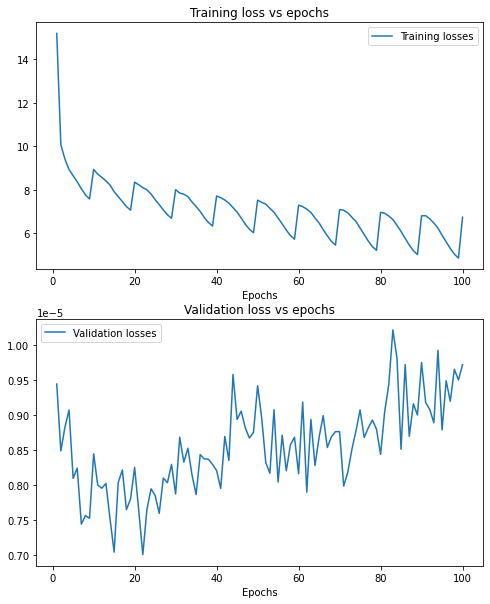

In [ ]:
# fig, (axe1, axe2) = plt.subplots(2)
fig = plt.figure(figsize=(8, 10), facecolor=(1, 1, 1))

axe1 = fig.add_subplot(2, 1, 1)
axe1.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
axe1.set_title('Training loss vs epochs')
axe1.set_xlabel('Epochs')
plt.legend()


axe2 = fig.add_subplot(2, 1, 2)
axe2.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
axe2.set_title('Validation loss vs epochs')
axe2.set_xlabel('Epochs')
plt.legend()

fig.savefig('model'+ model_args['model_num'] + '_loss.png')

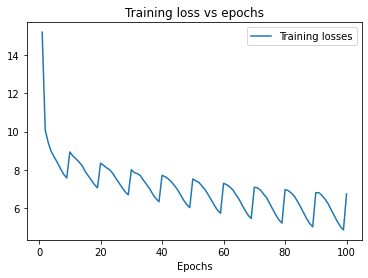

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Training loss vs epochs')
plt.plot(range(1, epochs + 1), training_loss_list, label='Training losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_training_loss.png', dpi=300)

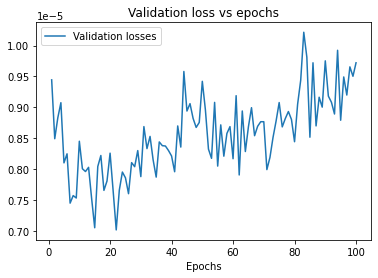

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('Validation loss vs epochs')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_validation_loss.png', dpi=300)

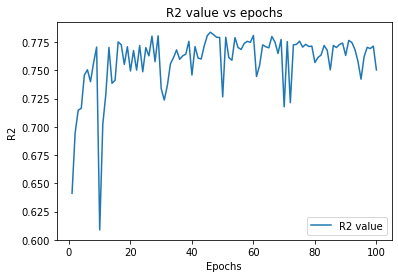

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.title('R2 value vs epochs')
plt.plot(range(1, epochs + 1), r2_list, label='R2 value')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()
plt.show()

fig.savefig('model'+ model_args['model_num'] + '_r2.png', dpi=300)